In [ ]:
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.interfaces.fsl import Randomise, Cluster, ApplyMask, Merge, Split
from nipype.interfaces.freesurfer.model import Binarize
from nipype.interfaces.nipy.preprocess import Trim

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Set study variables
analysis_home = '/home/camachocm2/Analysis/ChEC/fmri_proc'
raw_dir = analysis_home + '/raw'
preproc_dir = analysis_home + '/preproc'
firstlevel_dir = analysis_home + '/subjectlevel'
secondlevel_dir = analysis_home + '/grouplevel'
workflow_dir = analysis_home + '/workflows'
timing_file = analysis_home + '/misc/affect_tense_neg.txt'

mni_template = analysis_home + '/template/MNI152_T1_3mm_brain.nii.gz'
mni_brainmask = analysis_home + '/template/MNI152_T1_3mm_brain_mask.nii.gz'
gordon_parc = analysis_home + '/template/composite_Gordon_atlas_3mm.nii.gz'

t_contrasts = analysis_home + '/misc/tcon.con'
group_mat = analysis_home + '/misc/design.mat'

#subject_info = DataFrame.read_csv(analysis_home + '/../misc/subjs.csv')
#subjects_list = subject_info['SubjID'].tolist()
subjects_list = ['1000','1001','1002','1006','1007','1008','1011','1015','1016','1017']
#subjects_list = ['1000']

In [ ]:
## Data handling nodes

# grab data
templates = {'cope': 'copes/*/cope.nii.gz'}

selectfiles = Node(DataGrabber(outfields=['cope'],
                               sort_filelist=True,
                               base_directory=firstlevel_dir,
                               template='copes/*/cope.nii.gz',
                               field_template=templates),
                   name='selectfiles')

# Sink data of interest
datasink = Node(DataSink(base_directory = secondlevel_dir,
                         container = secondlevel_dir), 
                name='datasink')

In [20]:
def get_cluster_peaks(clusters_file, stat_file):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    from os.path import abspath
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    cluster_info_file = abspath(out_prefix + '_peaks.csv')
    return(cluster_info_file)

def extract_cluster_betas(cluster_index_file, sample_betas, min_clust_size, subject_ids):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>0]
    clusters = clusters[clusters>0]
    clusters = clusters[cluster_sizes>min_clust_size]
    cluster_sizes = cluster_sizes[cluster_sizes>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_betas
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'betas.txt'
        eb.run()
        betas = open('betas.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = Series(betas, index=sample_data.index)
    
    sample_data.to_csv(out_prefix+'_extracted_betas.csv')
    extracted_betas_csv = abspath(out_prefix+'_extracted_betas.csv')

    return(extracted_betas_csv)

def org_copes(copes_list):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nipype.interfaces.fsl import Split
    from glob import glob
    from os.path import dirname
    
    split = Split()
    split.inputs.dimension='t'
    
    subject_wise_list = []
    for file in copes_list:
        directory = dirname(file)
        split.inputs.out_base_name=directory+'/copenum'
        split.inputs.in_file = file
        split.run()
        
        
        sub_copes_list = glob(directory + '/copenum*.nii.gz')
        sub_copes_list = sorted(sub_copes_list)
        subject_wise_list.append(sub_copes_list)
        
    list_copes_list = list(map(list, zip(*subject_wise_list)))
    print(subject_wise_list)
    return(list_copes_list)


In [22]:
clusters_file = '/home/camachocm2/Analysis/ChEC/pilot_results/pilot_rois.nii.gz'
stat_file = '/home/camachocm2/Analysis/ChEC/fmri_proc/grouplevel/tstat_files/tension/randomise_tstat1.nii.gz'
sample_betas = '/home/camachocm2/Analysis/ChEC/fmri_proc/grouplevel/merged_copes/tension/cope_merged.nii.gz'
min_clust_size = 25
subject_ids = ['1000','1001','1002','1006','1007','1008','1011','1015','1016','1017']

cluster_info_file = get_cluster_peaks(clusters_file, stat_file)
extracted_betas_csv = extract_cluster_betas(clusters_file, sample_betas, min_clust_size, subject_ids)

In [ ]:
## Second Level Processing Nodes
#trim copes
trim_copes = MapNode(Trim(end_index=2, out_file='cope_trim.nii.gz'), 
                     name='trim_copes', 
                     iterfield=['in_file'])

# split copes
splitcopes = Node(Function(input_names=['copes_list'], 
                           output_names=['list_copes_list'], 
                           function=org_copes), 
                  name='splitcopes')

# Merge the copes to 1 4D file
mergecopes = MapNode(Merge(dimension='t'),
                     name='mergecopes', iterfield=['in_files'])

# FSL randomise for higher level analysis
highermodel = MapNode(Randomise(tfce=False,
                                mask=mni_brainmask,
                                num_perm = 5000,
                                tcon=t_contrasts,
                                raw_stats_imgs= True,
                                design_mat=group_mat),
                      name = 'highermodel', iterfield=['in_file'])

In [ ]:
L2workflow = Workflow(name='L2workflow_univariate')
L2workflow.connect([(selectfiles, trim_copes, [('cope','in_file')]),
                    (trim_copes, splitcopes, [('out_file','copes_list')]),
                    (splitcopes, mergecopes, [('list_copes_list','in_files')]),
                    (mergecopes, highermodel, [('merged_file','in_file')]),
                    
                    (mergecopes, datasink, [('merged_file','merged_copes')]),
                    (highermodel, datasink, [('tstat_files','tstat_files')])
                   ])
L2workflow.base_dir = workflow_dir
L2workflow.write_graph(graph2use='flat')
L2workflow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':10})


In [ ]:
template= {'merged_copes':secondlevel_dir + '/merged_copes/{condition}/cope_merged.nii.gz', 
           'tstat':secondlevel_dir + '/tstat_files/{condition}/randomise_tstat1.nii.gz'}
peakselectfiles = Node(SelectFiles(template),name='peakselectfiles')
peakselectfiles.iterables=('condition',['tension','negative'])

cluster =Node(Cluster(out_localmax_txt_file = 'cluster_stats.txt',
                      threshold=9,
                      out_index_file='clusters.nii.gz'), 
              name='cluster')

get_peaks = Node(Function(input_names=['clusters_file', 'stat_file'], 
                          output_names=['cluster_info_file'], 
                          function=get_cluster_peaks), 
                 name='get_peaks')

get_betas = Node(Function(input_names=['cluster_index_file', 'sample_betas', 
                                       'min_clust_size', 'subject_ids'], 
                          output_names=['extracted_betas_csv'], 
                          function=extract_cluster_betas), 
                 name='get_betas')
get_betas.inputs.subject_ids = subjects_list
get_betas.inputs.min_clust_size=25

In [ ]:
L2_peakworkflow = Workflow(name='L2_peakworkflow')
L2_peakworkflow.connect([(peakselectfiles, cluster,[('tstat','in_file')]),
                         (cluster, get_peaks, [('index_file','clusters_file')]),
                         (peakselectfiles, get_peaks, [('tstat','stat_file')]),
                         (cluster, get_betas ,[('index_file','cluster_index_file')]),
                         (peakselectfiles, get_betas, [('merged_copes','sample_betas')]),
                         
                         (get_peaks, datasink, [('cluster_info_file','cluster_stats')]),
                         (cluster, datasink, [('index_file','cluster_file')]),
                         (get_betas, datasink, [('extracted_betas_csv','cluster_betas')])
                        ])
L2_peakworkflow.base_dir = workflow_dir
L2_peakworkflow.write_graph(graph2use='flat')
L2_peakworkflow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':10})

leq_totneg predicts l_amyg R= 0.22 and P= 0.545.
leq_totneg predicts r_amyg R= -0.07 and P= 0.854.
leq_totneg predicts l_vmpfc R= 0.05 and P= 0.891.
leq_totneg predicts r_vmpfc R= -0.01 and P= 0.980.
leq_totneg predicts leq_totpos R= -0.12 and P= 0.749.
leq_totneg predicts leq_impneg R= 0.98 and P= 0.000.
leq_totneg predicts leq_imppos R= -0.13 and P= 0.718.
leq_totneg predicts cbcl_intern R= 0.46 and P= 0.176.
leq_totneg predicts cbcl_extern R= -0.16 and P= 0.666.
leq_totpos predicts l_amyg R= -0.30 and P= 0.400.
leq_totpos predicts r_amyg R= -0.34 and P= 0.332.
leq_totpos predicts l_vmpfc R= -0.24 and P= 0.501.
leq_totpos predicts r_vmpfc R= -0.29 and P= 0.419.
leq_totpos predicts leq_totneg R= -0.12 and P= 0.749.
leq_totpos predicts leq_impneg R= -0.07 and P= 0.839.
leq_totpos predicts leq_imppos R= 0.99 and P= 0.000.
leq_totpos predicts cbcl_intern R= -0.18 and P= 0.619.
leq_totpos predicts cbcl_extern R= -0.30 and P= 0.395.
leq_impneg predicts l_amyg R= 0.19 and P= 0.602.
leq_impn

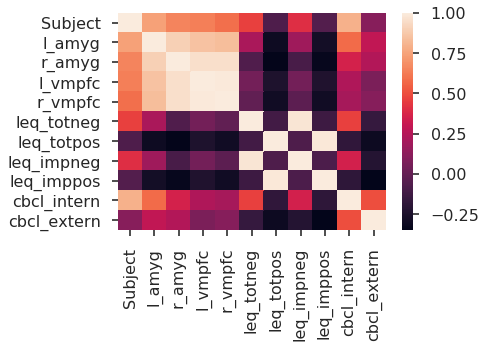

In [39]:
from pandas import read_csv, DataFrame

pilot_home = '/home/camachocm2/Analysis/ChEC/pilot_results/'
pilot = read_csv(pilot_home+'tension_pilot_rois_extracted_betas.csv',index_col=0)
pilot.head()

from scipy.stats import linregress

for x in pilot.columns.values[5:]:
    for y in pilot.columns.values[1:]:
        if not x==y:
            [slope, intercept, r_value, p_value, std_err] = linregress(pilot[x],pilot[y])
            print(x + ' predicts ' + y + ' R= ' + '%.2f'%round(r_value,2) + ' and P= ' + '%.3f'%round(p_value,3) + '.')

import seaborn as sns
corr = pilot.corr()
sns.heatmap(corr, #cmap=sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

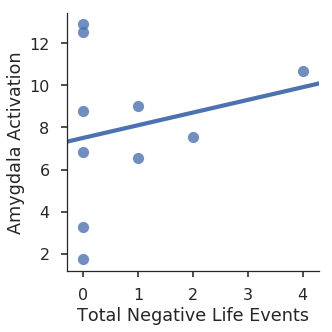

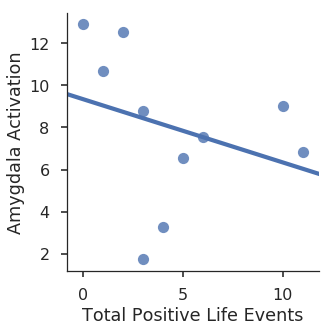

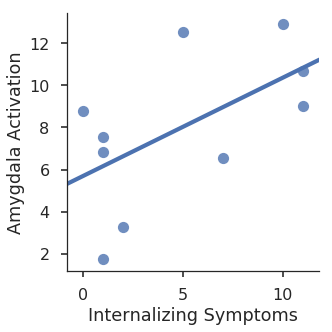

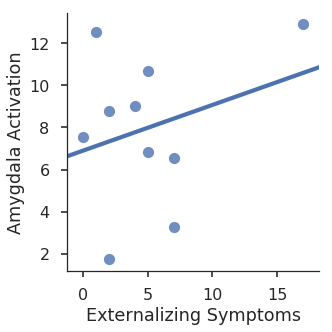

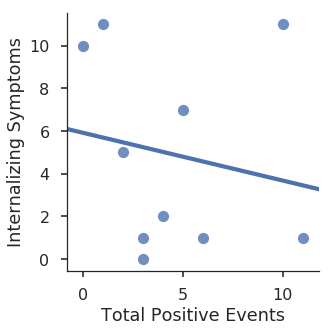

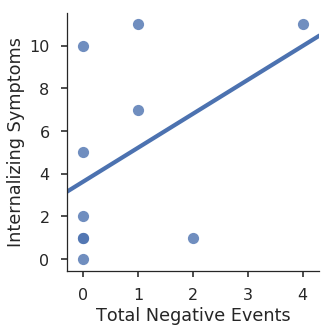

In [44]:
import matplotlib.pyplot as plt
sns.set(context='poster', style='ticks')

sns.lmplot('leq_totneg','l_amyg', data=pilot, ci=None)
plt.ylabel('Amygdala Activation')
plt.xlabel('Total Negative Life Events')
plt.savefig(pilot_home + 'tension_leqtotneg_lamyg.svg')

sns.lmplot('leq_totpos','l_amyg', data=pilot, ci=None)
plt.xlabel('Total Positive Life Events')
plt.ylabel('Amygdala Activation')
plt.savefig(pilot_home + 'tension_leqtotpos_lamyg.svg')

sns.lmplot('cbcl_intern','l_amyg', data=pilot, ci=None)
plt.xlabel('Internalizing Symptoms')
plt.ylabel('Amygdala Activation')
plt.savefig(pilot_home + 'tension_cbclintern_lamyg.svg')

sns.lmplot('cbcl_extern','l_amyg', data=pilot, ci=None)
plt.xlabel('Externalizing Symptoms')
plt.ylabel('Amygdala Activation')
plt.savefig(pilot_home + 'tension_cbclextern_lamyg.svg')

sns.lmplot('leq_totpos','cbcl_intern', data=pilot, ci=None)
plt.xlabel('Total Positive Events')
plt.ylabel('Internalizing Symptoms')
plt.savefig(pilot_home + 'cbclintern_totpos.svg')

sns.lmplot('leq_totneg','cbcl_intern', data=pilot, ci=None)
plt.xlabel('Total Negative Events')
plt.ylabel('Internalizing Symptoms')
plt.savefig(pilot_home + 'cbclintern_totneg.svg')